# RTA_Maps

### Process Flow :

1. load **merged dataset**    
2. choose filter criteria for data
3. choose map area to plot
4. generate map
5. save map picture

### Input data

**Areas**: Postcode areas shapes file from /data/Shapes directory  
**merged dataset**: 'RTA_unfiltered.pickle' from /data directory; generated by RTA_DS_Merged


### Output data

* saved map data assessment plot (.png) snapshots to data/Pics directory

### The following sources have been used:

Map Plotting:  http://www.datadependence.com/2016/06/creating-map-visualisations-in-python/   
UK geoJSONs:   https://mapzen.com/data/metro-extracts/metro/london_england/  
geoPandas:     https://vimeo.com/79535664


## Import external libraries

In [1]:
'''
Initialisation
* Import packages
* Initialise data
'''

#plot
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
import matplotlib.cm

%matplotlib inline

#Pandas
import pandas as pd
import geopandas as gpd

#utilities
import numpy as np
import time, os
import pickle

#path definitions
print(os.getcwd())

C:\GA\RTA - Copy


## 'Import' RTAutilities

In [2]:
'''
Provide output of csv and pickle formats for DataFrames
'''
def pick_and_csv(df, path, filename):
    import sys
    try:
        df.to_csv(path + filename + '.csv', index=False)
        df.to_pickle(path + filename + '.pickle')
    except IOError as (errno, strerror):
        print ('I/O error({0}): {1}'.format(errno, strerror))
        if errno == 13:
            print ('*** check to see if (someone has) file already open ***')
        elif errno == 2:
            print ('Directory parameter needs to be a valid directory')
    except:
        print ("Unexpected error:", sys.exc_info()[0])
        print ('*** is first parameter a DataFrame? ***')
        raise

In [3]:
'''
Map plot parameters by dataset field scenario
manual input point for road scenario configuration
'''

def road_scenarios(df, label):
    if label == 'mway': #3 mins
        df = df[(df.first_road_class == 1) | (df.first_road_class == 2)]
    elif label == 'speed_70': #7 mins (21k accidents)
        df = df[(df.speed_limit == 70)] 
    elif label == 'fatal': 
        df = df[(df.casualty_severity == 1)]
    elif label == 'motorbike': #6 mins (22k accidents)
        df = df[(df.vehicle_type > 1) & (df.vehicle_type < 6)]
    elif label == 'pushbike': #6 mins (22k accidents)
        df = df[(df.vehicle_type == 1)]
    return df

#(df.accident_severity <= 100) & 
#(df.speed_limit < 100) &
#& (df.sex_of_driver == 1)

In [4]:
'''
Map plot Area parameters by scenario
manual input point for road scenario configuration

resolution c, l, i, h, f or None. c:'course' f:'full' impacts plot time (20-120 seconds on my machine)

'''
def map_scenarios(scenario):
    p_parm_cols = ['scenario', 'resolution', 'projection', 'lat_0', 'lon_0', 
                   'llcrnrlon', 'llcrnrlat', 'urcrnrlon', 'urcrnrlat', 'Postcodes', 'PC_Max', 'PC_Min']
    p_parms = pd.DataFrame([
        ['Full_UK', 'f', 'merc', 54.5, -4.36, -10.7, 49.87, 2.06, 58.76, 'N', 0, 0],
        ['M25_M4_junct_d', 'c', 'merc', 51.494765, -0.494250, -0.504764, 51.487391, -0.480290, 51.500801, 'N', 0, 0],
        ['M25_M4_junct', 'c', 'merc', 51.494765, -0.494250, -0.505, 51.480, -0.481, 51.510, 'N', 0, 0],
        ['M25_M40_junction', 'c', 'merc', 51.494765, -0.494250, -0.555, 51.54, -0.51, 51.58, 'N', 0, 0],
        ['M25_M40_junction', 'c', 'merc', 51.494765, -0.494250, -0.555, 51.54, -0.51, 51.58, 'N', 0, 0],
        ['M25_AC_Road_1103', 'c', 'merc', 51.494765, -0.494250, -0.5, 51.35, -0.52, 51.4, 'N', 0, 0],
        ['M25', 'f', 'merc', 51.5, -4.36, -0.65, 51.2, 0.35, 51.8, 'N', 0, 0],
        ['Circular', 'f', 'merc', 51.5, -4.36, -0.3007507324,51.4360324921,0.0829124451,51.6204679324,'N', 0, 0],
        ['M4', 'c', 'merc', 51.5, -4.36, -5.7, 50, 1, 53, 'N', 0, 0],
        ['M25_North_segment', 'c', 'merc', 51.494765, -0.494250, -0.55, 51.487, -0.40, 51.5, 'N', 0, 0],
        ['Darenth', 'c', 'merc', 54.5, -4.36, 0.235, 51.41, 0.245, 51.435, 'N', 0, 0],
        ['Dartford', 'c', 'merc', 54.5, -4.36, 0.2, 51.4, 0.3, 51.5, 'N', 0, 0],
        ['Wide_M25_North_segment', 'c', 'merc', 54.5, -4.36, -0.65, 51.487, 0.3, 51.5, 'N', 0, 0],
        ['M24_A1M_junction', 'c', 'merc', 54.5, -4.36, -0.25, 51.67, -0.20, 51.70, 'N', 0, 0]
    ], columns=p_parm_cols)
    p_parms = p_parms.set_index(['scenario'])
    return p_parms.loc[scenario]

## Generate data for plot

In [5]:
'''
Generate data for plot
'''
#load data from pickle file
df_RTA_Road = pd.read_pickle('Data/RTA_unfiltered.pickle')
df_RTA_Road = df_RTA_Road[df_RTA_Road.latitude.notnull()]

print(df_RTA_Road.info())
df_RTA_Road.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 257792 entries, 0 to 257791
Data columns (total 57 columns):
accident_index                                 257792 non-null object
location_easting_osgr                          257792 non-null float64
location_northing_osgr                         257792 non-null float64
longitude                                      257792 non-null float64
latitude                                       257792 non-null float64
police_force                                   257792 non-null float64
accident_severity                              257792 non-null float64
number_of_vehicles                             257792 non-null float64
number_of_casualties                           257792 non-null float64
date                                           257792 non-null object
day_of_week                                    257792 non-null float64
time                                           257759 non-null object
local_authority_(district)              

,accident_index,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,date,...,journey_purpose_of_driver,sex_of_driver,age_of_driver,age_band_of_driver,engine_capacity,propulsion_code,age_of_vehicle,driver_imd_decile,driver_home_area_type,vehicle_imd_decile
0,201501BS70001,525130.0,180050.0,-0.198465,51.505538,1.0,3.0,1.0,1.0,12/01/2015,...,1,1,-1,-1,2143,2,4,-1,-1,-1
1,201501BS70002,526530.0,178560.0,-0.178838,51.491836,1.0,3.0,1.0,1.0,12/01/2015,...,6,1,-1,-1,1600,1,3,-1,-1,-1
2,201501BS70004,524610.0,181080.0,-0.205590,51.514910,1.0,3.0,1.0,1.0,12/01/2015,...,6,1,30,6,1686,2,10,-1,1,-1
3,201501BS70005,524420.0,181080.0,-0.208327,51.514952,1.0,3.0,1.0,1.0,13/01/2015,...,6,1,-1,-1,-1,-1,-1,-1,-1,-1
4,201501BS70008,524630.0,179040.0,-0.206022,51.496572,1.0,2.0,2.0,1.0,09/01/2015,...,2,1,48,8,0,-1,-1,-1,1,-1


In [6]:
#generate areas dataframe
df_Areas = pd.DataFrame(df_RTA_Road.accident_index.groupby(df_RTA_Road.Areas).count())
df_Areas.columns = ['count']
df_Areas = df_Areas.reset_index()

print(df_Areas.info())
df_Areas.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 2 columns):
Areas    120 non-null object
count    120 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.9+ KB
None


,Areas,count
0,AB,1021
1,AL,1052
2,B,8633
3,BA,1553
4,BB,2231


## Choose map scenario

In [7]:
#'Manual' input point for scenario choice
map_scenario = 'Full_UK'
road_scenario = 'motorbike'
png_filename = 'Data/Pics/Map_'+ map_scenario + '_' + road_scenario +'.png'
sp = map_scenarios(map_scenario)
df_RTA_Road = road_scenarios(df_RTA_Road, road_scenario)

## Plot UK map data

C:\Users\Iain\Anaconda3\envs\GA\lib\site-packages\mpl_toolkits\basemap\__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
C:\Users\Iain\Anaconda3\envs\GA\lib\site-packages\mpl_toolkits\basemap\__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Users\Iain\Anaconda3\envs\GA\lib\site-packages\mpl_toolkits\basemap\__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


Total Plot time: 395.578999996 seconds 


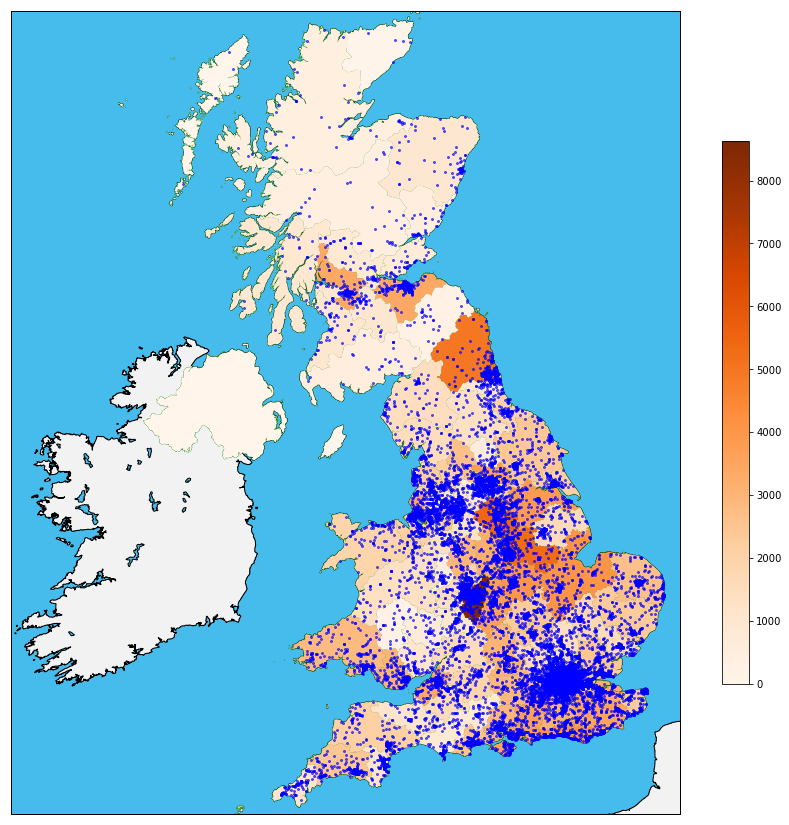

In [8]:
'''
Plot UK Map with postcodes and accident data

adapted from:  http://www.datadependence.com/2016/06/creating-map-visualisations-in-python/   
'''

start_time_MD = time.time()

def plot_accidents(pos):
    global ec
    try:
        x, y = m(pos[1], pos[0])
        m.plot(x, y, 'o', markersize=2, color='blue', alpha=0.6)
    except:
        ec +=1
        if pos == 0:
            print 'Zero Exception in plot_accidents %s' % ec
        else:
            print 'pos[1]: %s' % pos[1]
            print 'pos[0]: %s' % pos[0]
            print 'm(pos[1], pos[0]): %s' % m(pos[1], pos[0])
        

# create map segment and resolution
fig, ax = plt.subplots(figsize=(15,25))
m = Basemap(resolution=sp[0], #c, l, i, h, f or None
            projection=sp[1], #always 'merc'
            lat_0 = sp[2], lon_0 = sp[3], #centre coords
            llcrnrlon = sp[4], llcrnrlat = sp[5], #lower left coords
            urcrnrlon = sp[6], urcrnrlat = sp[7]) #uper right coords

# Draw map
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
m.drawcoastlines()
m.readshapefile('Data/Shapes/Areas', 'Areas', color = 'green')
#m.readshapefile('Data/Shapes/Data/GB/district_boundaries', 'regions', color = 'green')

'''
Create a new DataFrame for convenience that will hold all the information we need.
'''
df_poly = pd.DataFrame({
    'shapes': [Polygon(np.array(shape), True) for shape in m.Areas],
    'Areas': [x['name'] for x in m.Areas_info]
})

df_poly = df_poly.merge(df_Areas, on='Areas', how='left')

'''
use this information to colour in the areas
Other colourmaps: http://matplotlib.org/examples/color/colormaps_reference.html

'''
cmap = plt.get_cmap('Oranges')
pc = PatchCollection(df_poly.shapes, zorder=2)
norm = Normalize() # vmin=0, vmax=900)
pc.set_facecolor(cmap(norm(df_poly['count'].fillna(0).values)))
ax.add_collection(pc)

'''
Add a colorbar, this makes it at lot easier to interpret the colours of the map and relate them to a number.
'''
mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

mapper.set_array(df_poly['count'])
plt.colorbar(mapper, shrink=0.4)

ec=0
df_RTA_Road.Acc_coord.apply(plot_accidents)

plt.savefig(png_filename)

print "Total Plot time: %s seconds " % (time.time() - start_time_MD)